In [89]:
import numpy as np
import time
import os

%load_ext autoreload
%autoreload 2

# utilities
import utils_data as utlD

from PDA import PDA


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [91]:
netpath = 'mnist_model.pt'
net = utlC.get_net(netpath)

In [92]:
netname = 'mnist'
path_data = './test_data'
classnames = list(map(str, range(0, 10)))

# pick for which layers the explanations should be computed
# (names depend on network, output layer is usually called '-1')
layer_numbers = [-1]

# is torch running in gpu mode?
gpu = False

# window size (i.e., the size of the pixel patch that is marginalised out in each step)
win_size = 5               # k in alg 1 (see paper)

# indicate whether windows should be overlapping or not
overlapping = True

# settings for sampling 
sample_style = 'conditional' # choose: conditional / marginal
num_samples = 10
padding_size = 3            # important for conditional sampling,
                            # l = win_size+2*padding_size in alg 1
                            # (see paper)

# set the batch size - the larger, the faster computation will be
batch_size = 64


# get the data
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

X_test, X_test_im, X_filenames = utlD.get_data(path_data, transformation)

In [93]:
pda = PDA(netname, net, X_test_im, classnames, layer_numbers, win_size, padding_size, gpu, batch_size,
          overlapping, sample_style, num_samples)

In [94]:
ind = 2
pred_diffs = pda.run(X_test[ind])

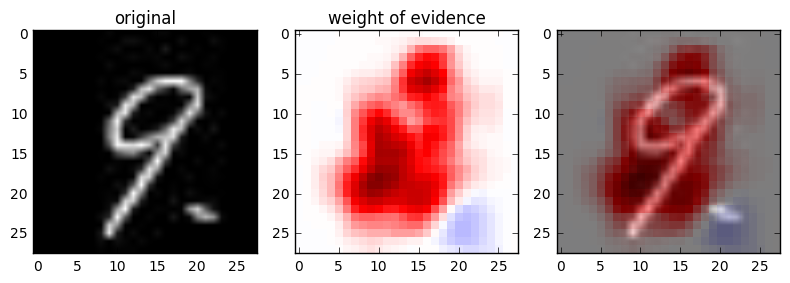

In [95]:
pda.plot(X_test_im[ind], pred_diffs[0], class_indx=9)

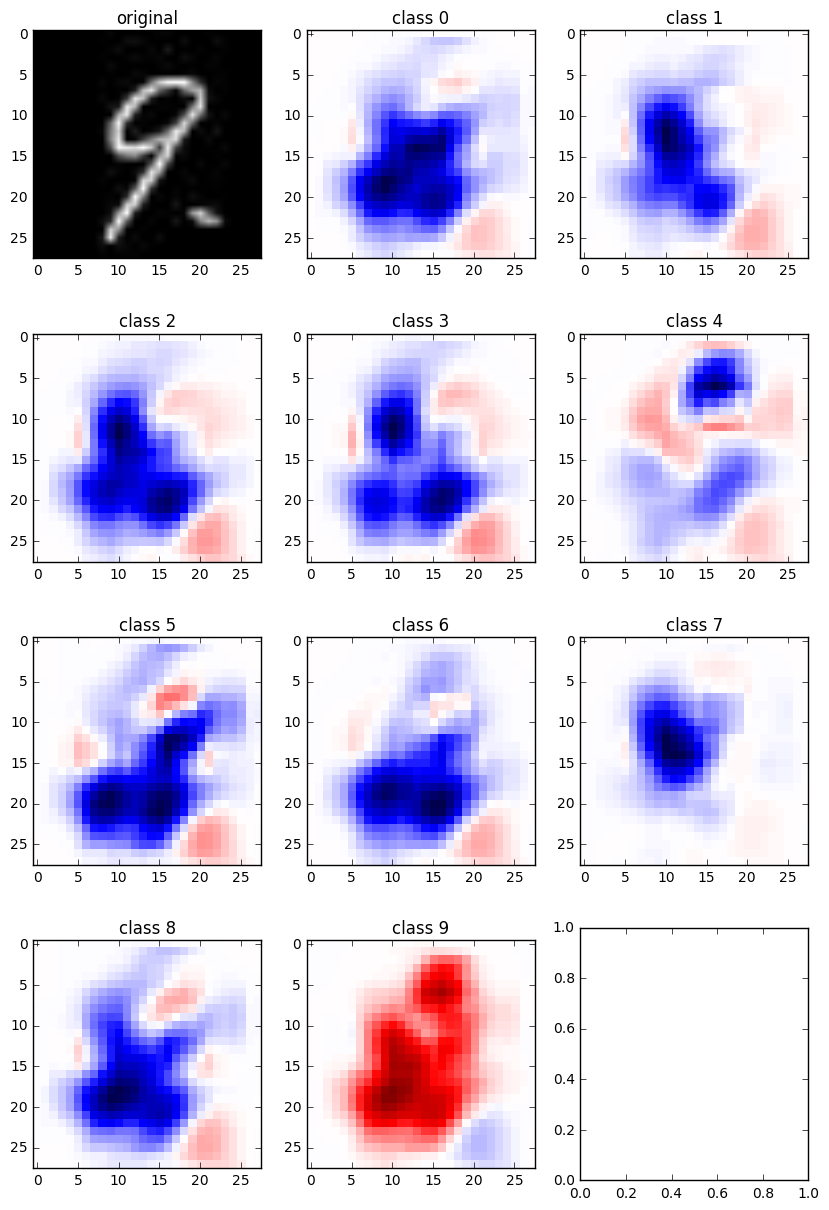

In [96]:
pda.plot_maps(X_test_im[ind], pred_diffs[0])